In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_theme(style="darkgrid")

# Single Plot

In [94]:
file_path = "acquisitions/consumption/raw_3.7V_10Hz.csv"
data = pd.read_csv(file_path)

battery_level = 3.7
frequency = 10

# Display the first few rows of the dataframe to understand its structure
data.head()

,Index,Reading,Unit,Range Digits,Disp Digits,Math,Start Group,Limit1 High,Limit1 Low,Limit2 High,...,Value,Unit.1,Digits,Output,Sense,Source Limit,Overtemp,Date,Time,Fractional Seconds
0,1,0.011084,Amp DC,0.1,6.5,F,F,F,F,F,...,3.703590,Volt DC,10,T,2W,F,F,03/04/2024,18:58:20,0.665961
1,2,0.007740,Amp DC,0.1,6.5,F,F,F,F,F,...,3.694614,Volt DC,10,T,2W,F,F,03/04/2024,18:58:20,0.669410
2,3,0.007436,Amp DC,0.1,6.5,F,F,F,F,F,...,3.698296,Volt DC,10,T,2W,F,F,03/04/2024,18:58:20,0.672854
3,4,0.007273,Amp DC,0.1,6.5,F,F,F,F,F,...,3.697461,Volt DC,10,T,2W,F,F,03/04/2024,18:58:20,0.676270
4,5,0.007691,Amp DC,0.1,6.5,F,F,F,F,F,...,3.696310,Volt DC,10,T,2W,F,F,03/04/2024,18:58:20,0.679683


In [95]:
# Keeping only the necessary columns and merging 'Time' and 'Fractional Seconds'
data_cleaned = data[['Reading', 'Value', 'Date', 'Time', 'Fractional Seconds']].copy()

# Merging 'Time' and 'Fractional Seconds' into a single 'DateTime' column
# The fractional seconds will be added as milliseconds to the 'Time' column
data_cleaned['DateTime'] = pd.to_datetime(data_cleaned['Date'] + ' ' + data_cleaned['Time']) + pd.to_timedelta(data_cleaned['Fractional Seconds'], unit='s')

# Dropping the original 'Date', 'Time', and 'Fractional Seconds' columns as they are now merged into 'DateTime'
data_cleaned.drop(['Date', 'Time', 'Fractional Seconds'], axis=1, inplace=True)
# Converting current from Amperes to milliamperes (mA)
data_cleaned['Reading'] = data_cleaned['Reading'] * 1000
# Displaying the updated DataFrame to ensure correctness
data_cleaned.head()


,Reading,Value,DateTime
0,11.083500,3.703590,2024-03-04 18:58:20.665960760
1,7.739648,3.694614,2024-03-04 18:58:20.669410060
2,7.436346,3.698296,2024-03-04 18:58:20.672854340
3,7.273328,3.697461,2024-03-04 18:58:20.676270160
4,7.690871,3.696310,2024-03-04 18:58:20.679682860


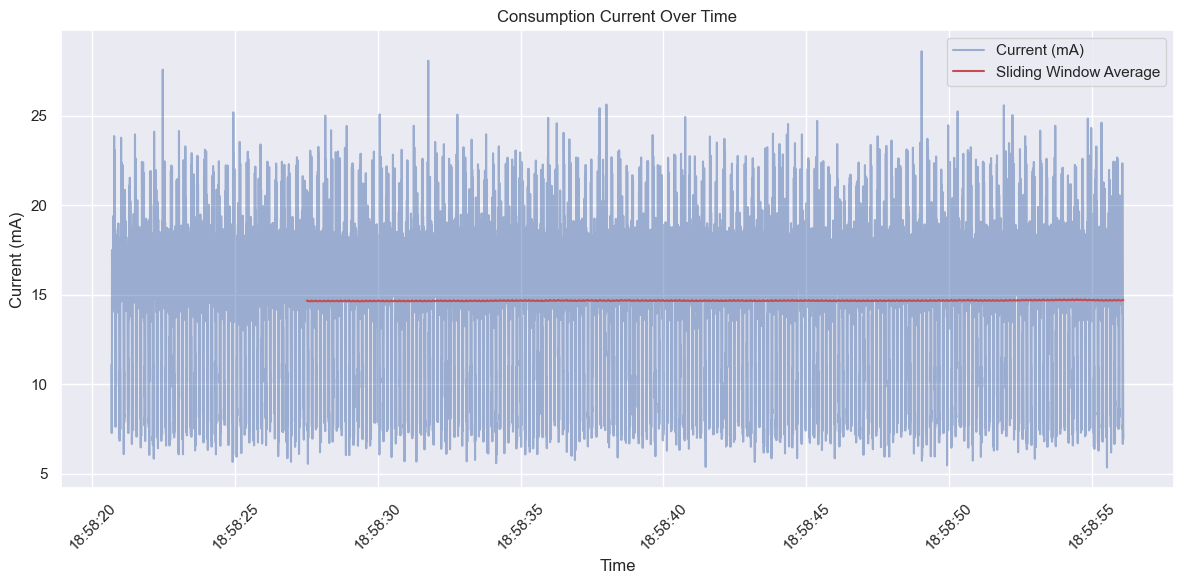

In [96]:
# Calculating a sliding window average (rolling mean) with a window size of 10
window_size = 2000
data_cleaned['Rolling Current'] = data_cleaned['Reading'].rolling(window=window_size).mean()
data_cleaned['Rolling Voltage'] = data_cleaned['Value'].rolling(window=window_size).mean()
# Creating the plot with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_cleaned, x='DateTime', y='Reading', label='Current (mA)', color='C0', alpha=0.5)
sns.lineplot(data=data_cleaned, x='DateTime', y='Rolling Current', label='Sliding Window Average', color='C3')

plt.title('Consumption Current Over Time')
plt.xlabel('Time')
plt.ylabel('Current (mA)')
plt.legend()

# Rotate date labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

plt.show()


In [97]:
seconds = 10

# take last 5 seconds of rolling mean, 1 second = 291 samples
last_seconds = data_cleaned.tail(291*seconds)
# calculate mean of last 5 seconds
mean_current = last_seconds['Rolling Current'].mean()

print(f"Mean current over the last 5 seconds: {mean_current:.2f} mA")

# map the x axis from 0 to 5 seconds
last_seconds['DateTime'] = last_seconds['DateTime'] - last_seconds['DateTime'].iloc[0]
last_seconds['DateTime'] = last_seconds['DateTime'].dt.total_seconds()

Mean current over the last 5 seconds: 14.68 mA


C:\Users\MegaN\AppData\Local\Temp\ipykernel_20180\3416198924.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_seconds['DateTime'] = last_seconds['DateTime'] - last_seconds['DateTime'].iloc[0]
C:\Users\MegaN\AppData\Local\Temp\ipykernel_20180\3416198924.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_seconds['DateTime'] = last_seconds['DateTime'].dt.total_seconds()


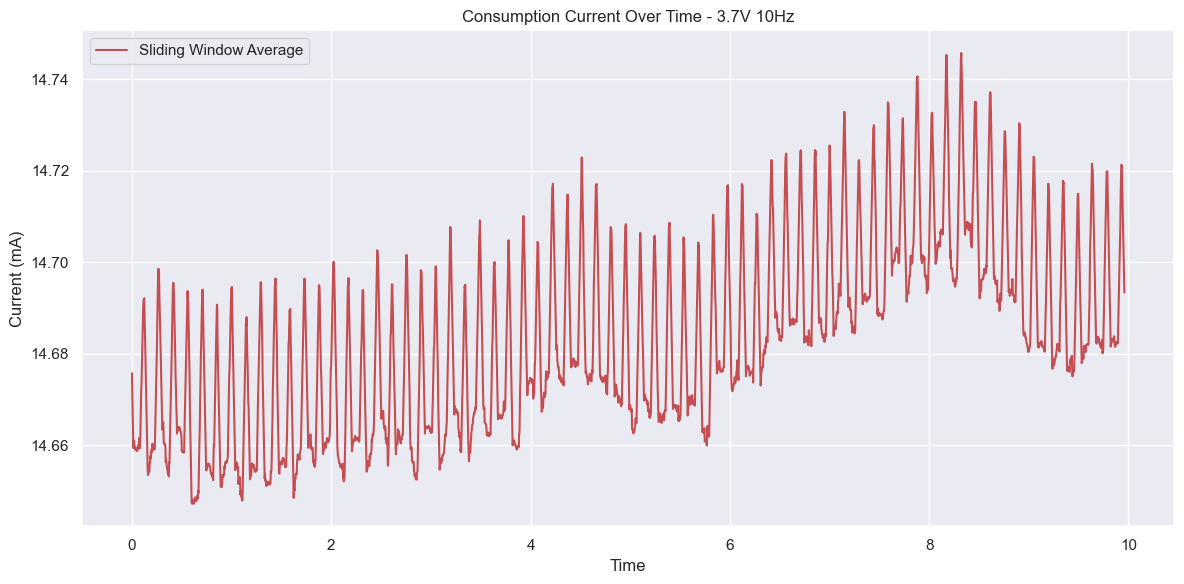

In [98]:
# plot last 5 seconds
plt.figure(figsize=(12, 6))
# sns.lineplot(data=last_seconds, x='DateTime', y='Reading', label='Current (mA)', color='C0', alpha=0.5)
sns.lineplot(data=last_seconds, x='DateTime', y='Rolling Current', label='Sliding Window Average', color='C3')

plt.title('Consumption Current Over Time - '+str(battery_level)+'V '+str(frequency)+'Hz')
plt.xlabel('Time')
plt.ylabel('Current (mA)')
plt.legend()

plt.tight_layout()  # Adjust layout to make room for the rotated date labels

plt.show()

# create a dataframe with the last seconds with 'DateTime', 'Rolling Current', 'Rolling Voltage' , 'Battery Level', 'Frequency'
last_seconds = last_seconds[['DateTime', 'Rolling Current', 'Rolling Voltage']]
last_seconds['Battery Level'] = battery_level
last_seconds['Frequency'] = frequency
# save the last seconds to a csv file
last_seconds.to_csv('consumption_'+str(battery_level)+'V_'+str(frequency)+'Hz.csv', index=False)

In [99]:
# Given values
battery_capacity_mAh = 100  # Battery capacity in mAh
mean_current_mA = mean_current  # Average power consumption in mA

# Convert capacity from mAh to Ah
battery_capacity_Ah = battery_capacity_mAh / 1000

# Convert current from mA to A
average_current_A = mean_current_mA / 1000

# Calculate the lasting time of the battery
lasting_time_hours = battery_capacity_Ah / average_current_A

lasting_time_hours


6.810306354400926

# Combined Plot

In [102]:
# import the data
file_path = "acquisitions/consumption/all_consumption.csv"

data = pd.read_csv(file_path)

data.head()

,DateTime,Rolling Current,Rolling Voltage,Battery Level,Frequency
0,0.000000,14.675787,3.700711,3.7,10
1,0.003428,14.671601,3.700711,3.7,10
2,0.006848,14.667747,3.700711,3.7,10
3,0.010270,14.663749,3.700712,3.7,10
4,0.013697,14.659436,3.700713,3.7,10


In [104]:
# group by Battery Level and Frequency and calculate the mean of the Lasting Time
data_grouped = data.groupby(['Battery Level', 'Frequency']).mean().reset_index()

data_grouped

,Battery Level,Frequency,DateTime,Rolling Current,Rolling Voltage
0,3.7,10,4.979422,14.683627,3.700685
1,3.7,20,4.978695,14.715752,3.700680
2,3.7,30,4.979214,14.784242,3.700504
3,4.0,10,4.975478,13.914613,3.999951
4,4.0,20,4.974871,13.994288,3.999863
5,4.0,30,4.979214,14.784242,3.700504
6,4.2,10,4.980497,13.517170,4.200191
7,4.2,20,4.981929,13.581863,4.200049
8,4.2,30,4.979878,13.664917,4.200021
